In [1]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.finance import candlestick_ochl
%matplotlib inline

C:\Users\eriks\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def get_data_for_coin(coin):
    url = "https://min-api.cryptocompare.com/data/histohour?fsym={coin}&tsym=BTC&limit=10000&aggregate=1&e=CCCAGG"
    url = url.format(coin=coin)

    data = json.loads(requests.get(url).content.decode("utf-8"))["Data"]
    data = pd.DataFrame(data)
    data['close'] = pd.to_numeric(data['close'])
    data['high'] = pd.to_numeric(data['high'])
    data['low'] = pd.to_numeric(data['low'])
    data['time'] = pd.to_numeric(data['time'])
    data['time'] = pd.to_datetime(data['time'], errors='coerce', unit='s')
    data['rollingTenkanMax'] = data['high'].rolling(center=False, window=20).max()
    data['rollingTenkanMin'] = data['low'].rolling(center=False, window=20).min()

    data['rollingKijunMax'] = data['high'].rolling(center=False, window=60).max()
    data['rollingKijunMin'] = data['low'].rolling(center=False, window=60).min()

    data['senkouBMax'] = data['high'].rolling(center=False, window=120).max()
    data['senkouBMin'] = data['low'].rolling(center=False, window=120).min()

    data['tenkan'] = (data['rollingTenkanMax'] + data['rollingTenkanMin'])/2
    data['kijun'] = (data['rollingKijunMax'] + data['rollingKijunMin'])/2
    data['senkouA'] = (data['tenkan'] + data['kijun'])/2
    data['senkouB'] = (data['senkouBMax'] + data['senkouBMin'])/2
    data.set_index(['time'],inplace=True)
    return data


In [3]:
def add_cloud(coin):
    data = get_data_for_coin(coin)
    last_date = data.index[-1:]
    new_indexes = [(last_date + pd.DateOffset(hours=i)).to_pydatetime()[0] for i in range(1,31)]
    old_indexes = data.index.to_pydatetime()

    senkou_df = pd.DataFrame(data)
    for _ in range(30):
        senkou_df = senkou_df.append(pd.Series([np.nan]), ignore_index=True)

    indexes = list(old_indexes) + new_indexes
    senkou_df.index = indexes
    senkou_df['senkouA'] = senkou_df['senkouA'].shift(30)
    senkou_df['senkouB'] = senkou_df['senkouB'].shift(30)
    return senkou_df

In [ ]:
def plot_ichimoku(coin):
    data = add_cloud(coin)[-100:]
    fig = plt.figure(figsize=(15,8))
    ax_price = fig.add_subplot(111) # in this function, first number 1 represent the height,
    # second is for width and third is the plot number
    ax_tenkan = fig.add_subplot(111) # make sure both have same arguments for add_subplot function

    ochl = [[mdates.date2num(idx),  data['open'], data['close'], data['high'], data['low']] for idx, data in data.iterrows()]

    plt.xticks(rotation=-45)

    # it is in the same expected order    date,open,high,low,close
    candlestick_ochl(ax_price, ochl, width=0.01, colorup='g', colordown='r', alpha=0.5)
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax_price.xaxis.set_major_locator(mticker.MaxNLocator(4))
    ax_price.grid(True)
    ax_price.set_xticks(data.index[::5])

    ax_tenkan.plot([mdates.date2num(dt) for dt in data.index], data["tenkan"] ,color = 'b')
    ax_tenkan.plot([mdates.date2num(dt) for dt in data.index], data["kijun"] ,color = 'y')
    ax_tenkan.plot([mdates.date2num(dt) for dt in data.index], data["senkouA"],color = 'r')
    ax_tenkan.plot([mdates.date2num(dt) for dt in data.index], data["senkouB"],color = 'r')

    ax_tenkan.fill_between(
        [mdates.date2num(dt) for dt in data.index],
        data["senkouA"],
        data["senkouB"],
        where=data["senkouA"]<=data["senkouB"],
        facecolor='red'
    )
    ax_tenkan.fill_between(
        [mdates.date2num(dt) for dt in data.index],
        data["senkouA"],
        data["senkouB"],
        where=data["senkouA"]>=data["senkouB"],
        facecolor='green'
    )

    plt.title(coin)
    # make sure in the second plot, the xaxis is also like date type converted to number by date2num function
    plt.show()

C:\Users\eriks\Anaconda3\lib\site-packages\pandas\core\frame.py:4319: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  other.index).difference(self.columns).tolist()
C:\Users\eriks\Anaconda3\lib\site-packages\pandas\core\frame.py:4319: RuntimeWarning: unorderable types: numpy.ndarray() < str(), sort order is undefined for incomparable objects
  other.index).difference(self.columns).tolist()


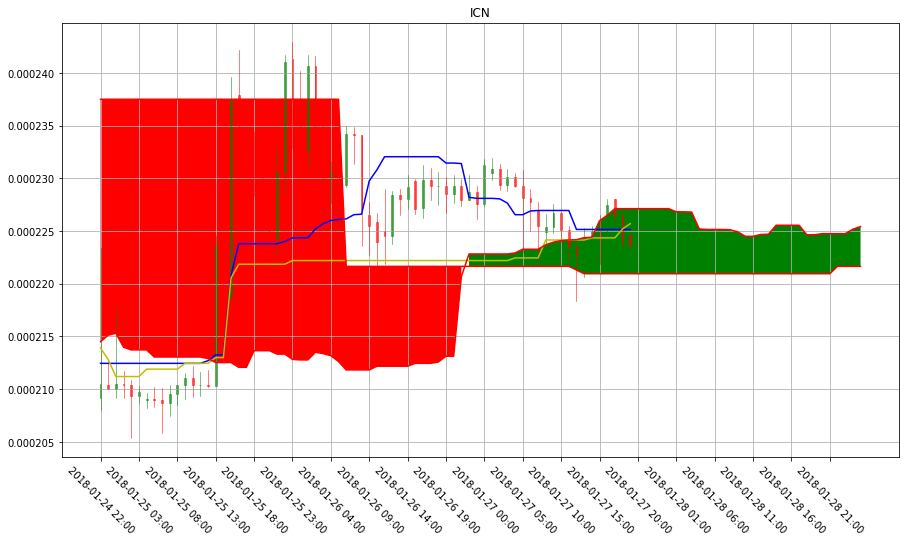

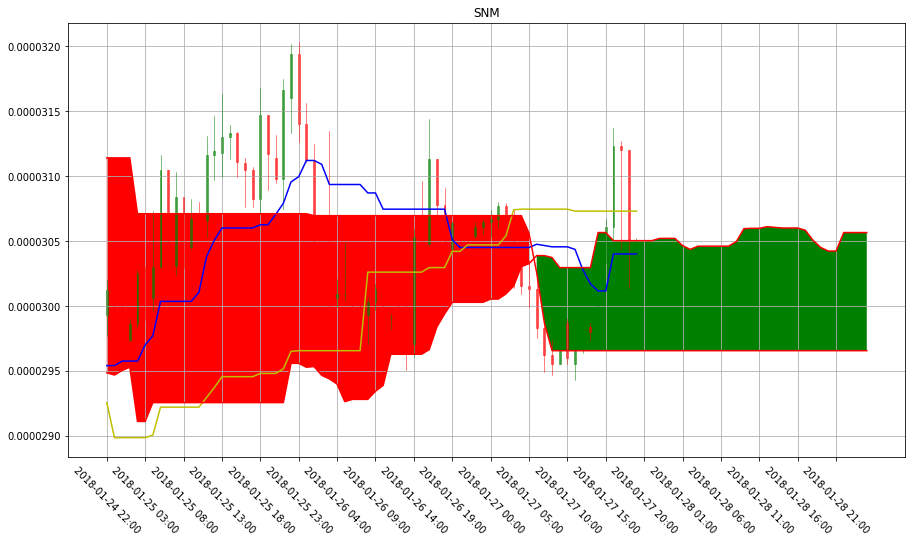

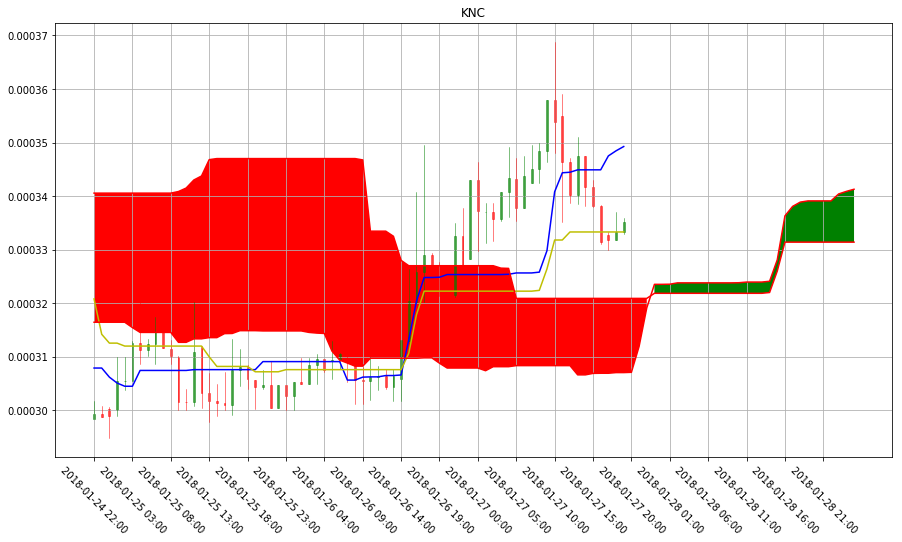

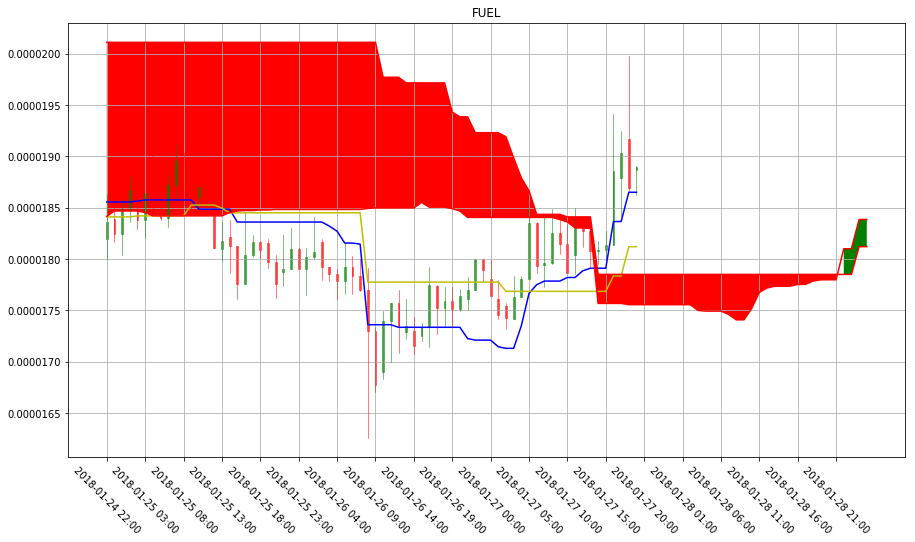

BTC


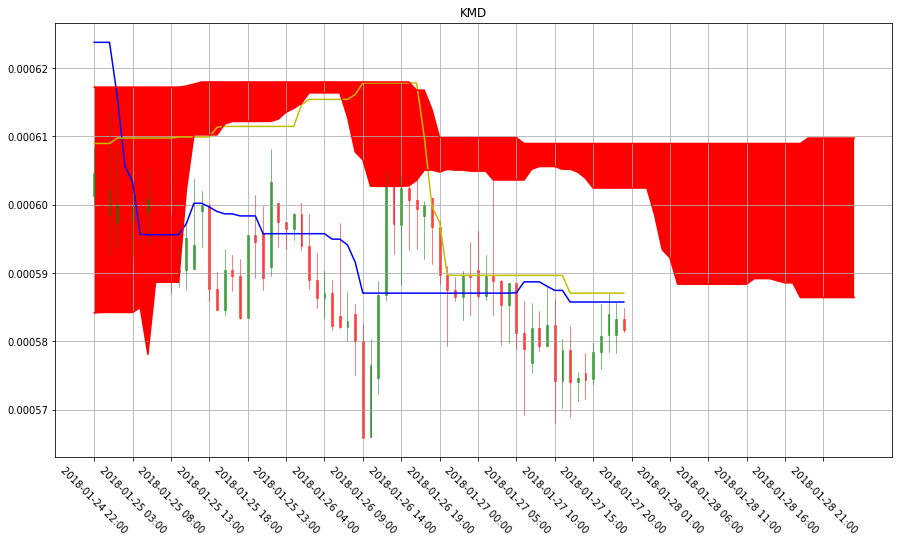

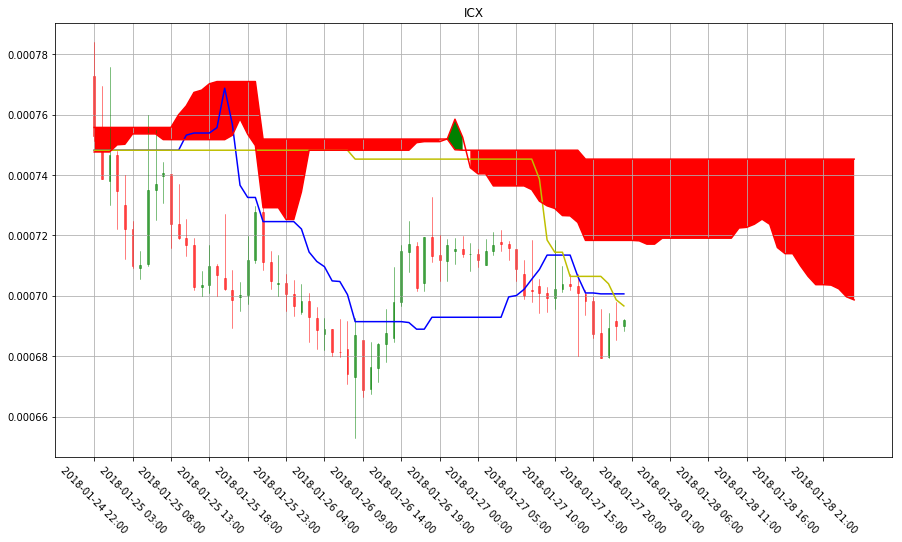

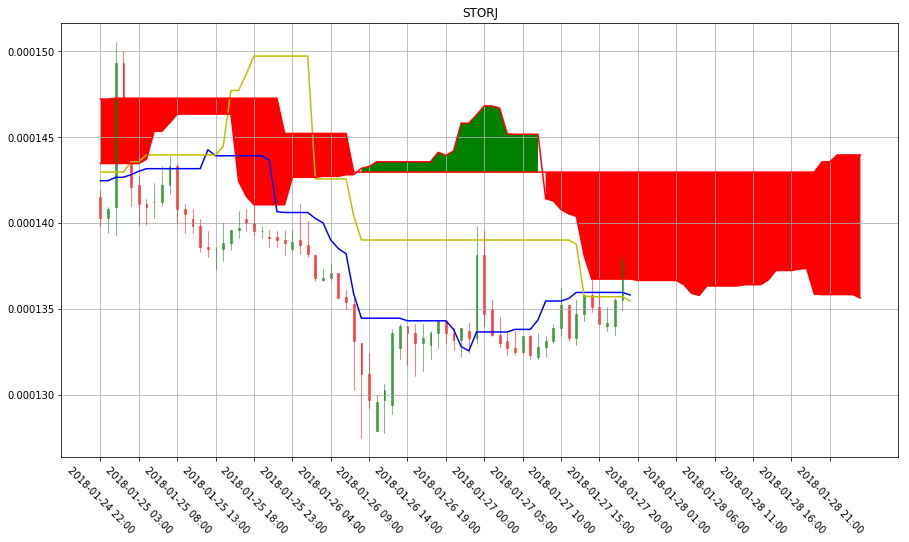

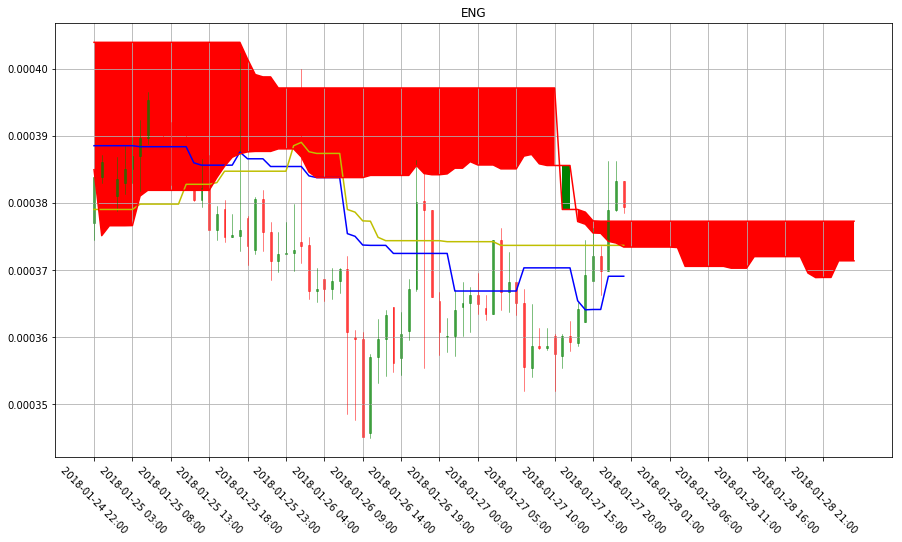

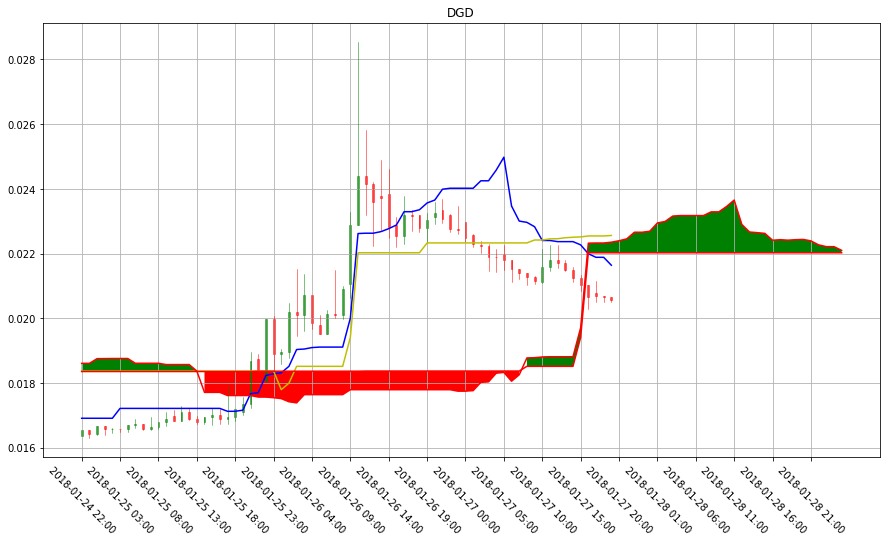

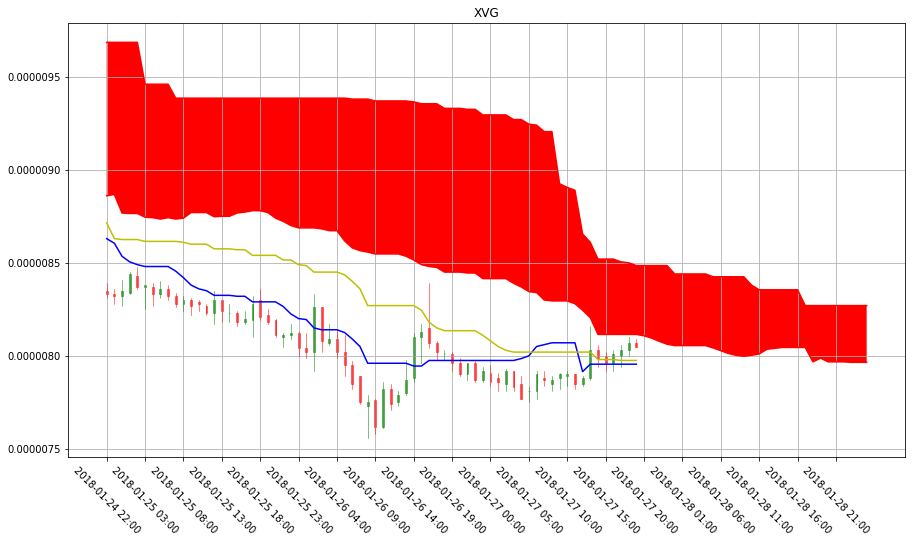

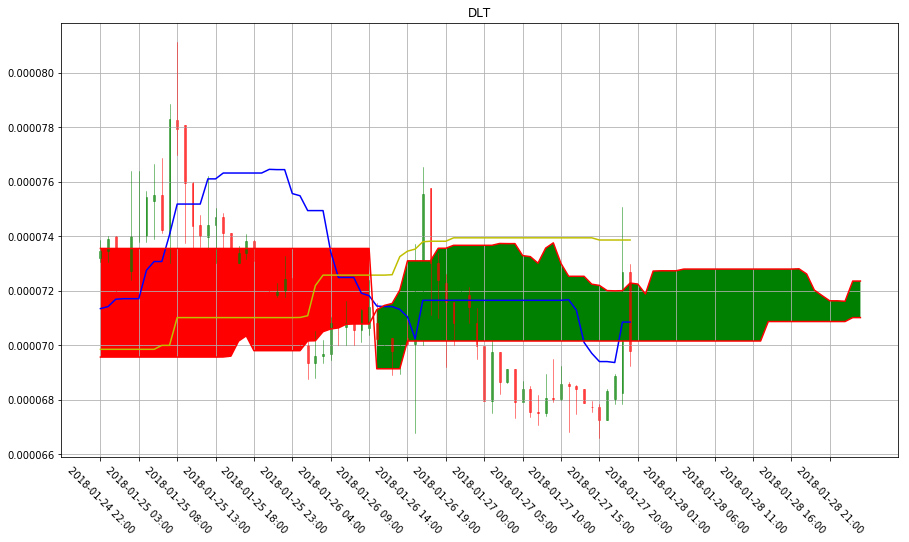

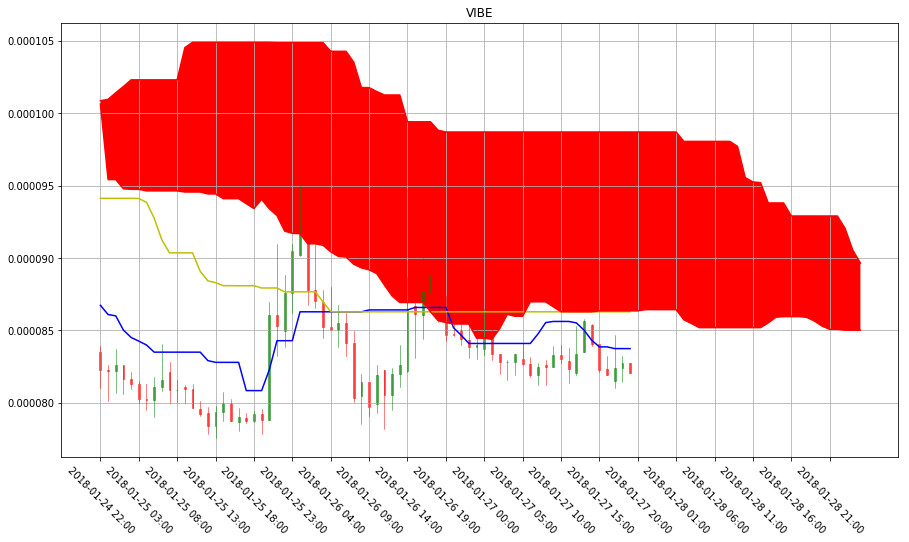

IOTA


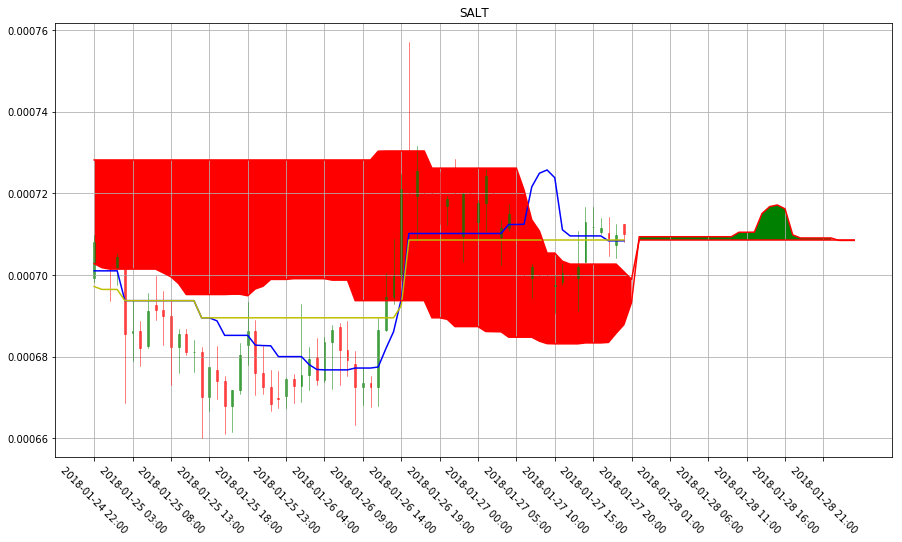

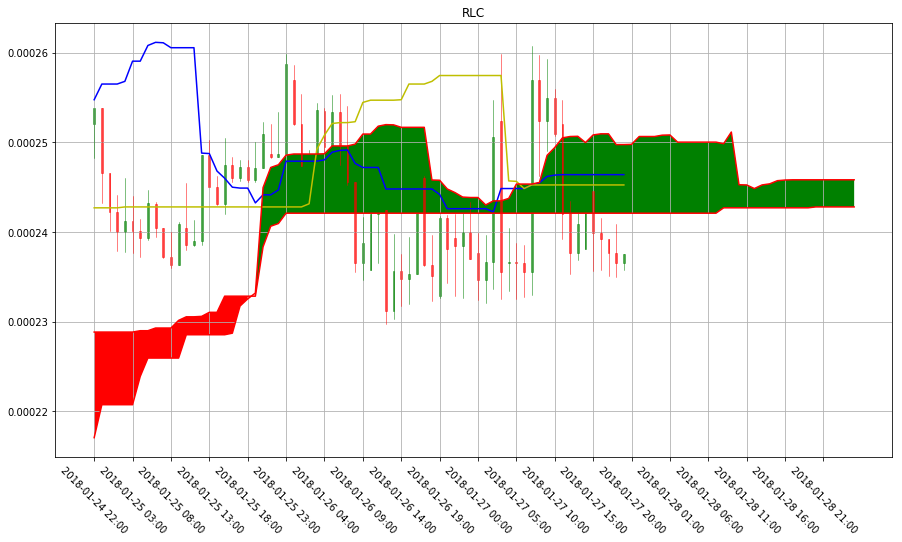

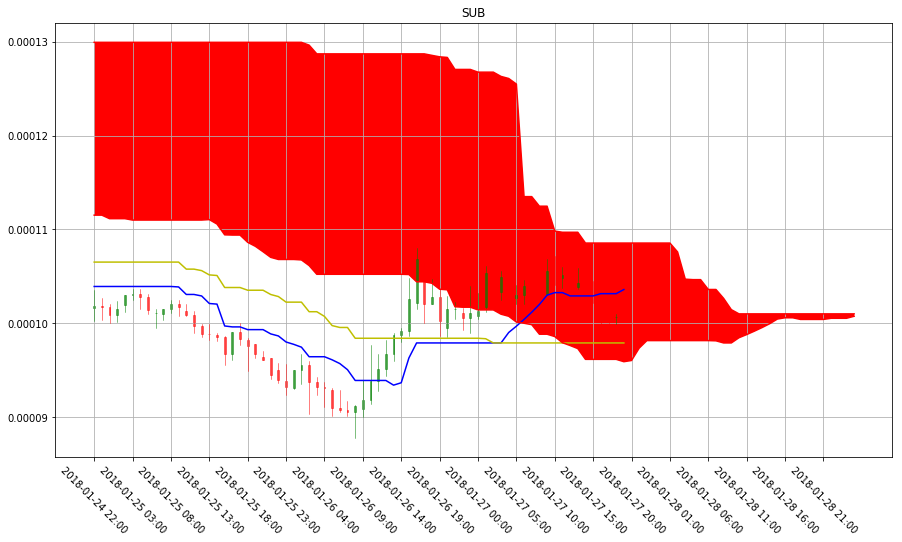

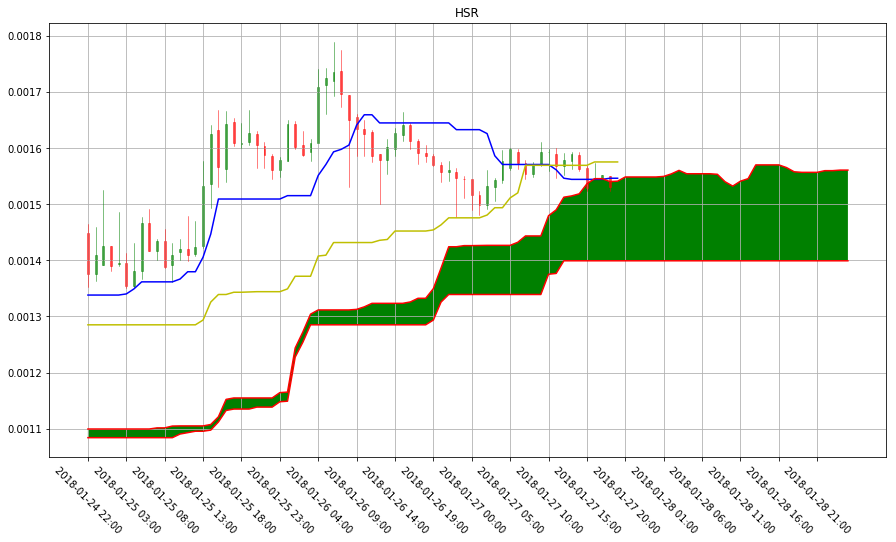

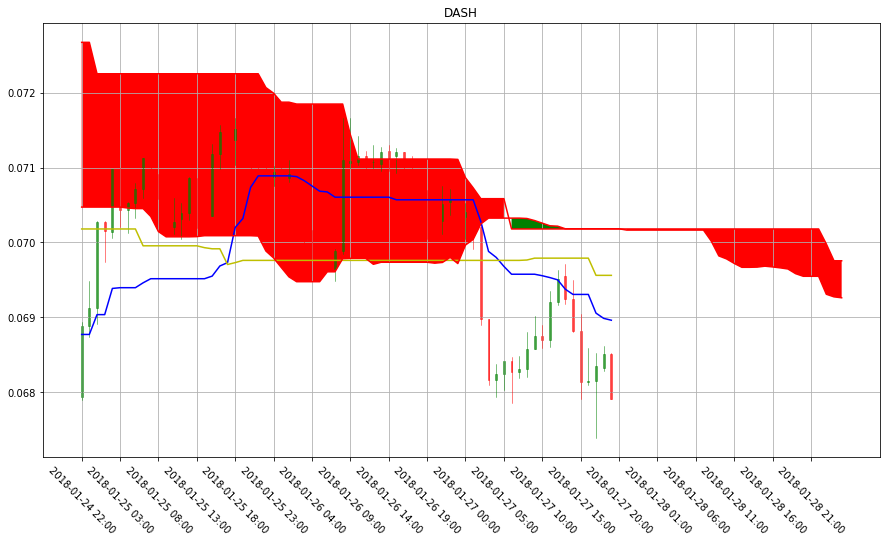

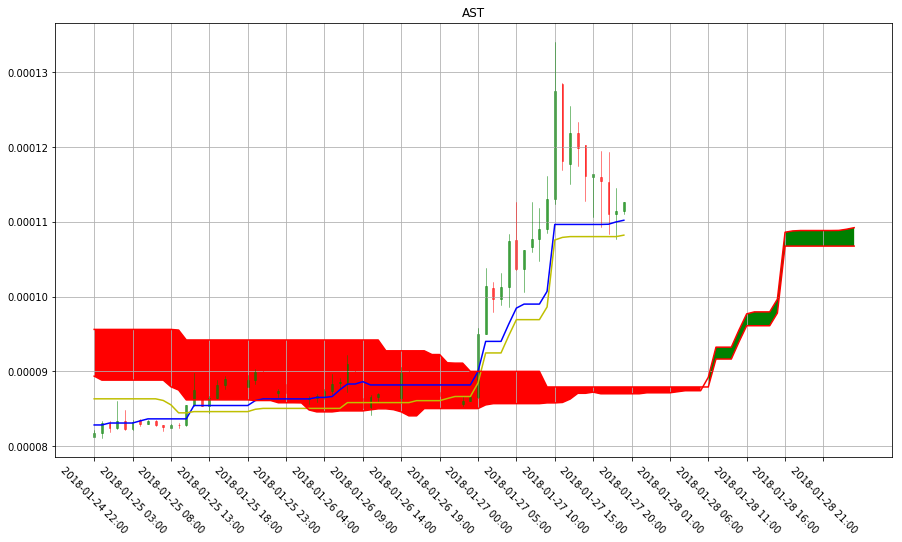

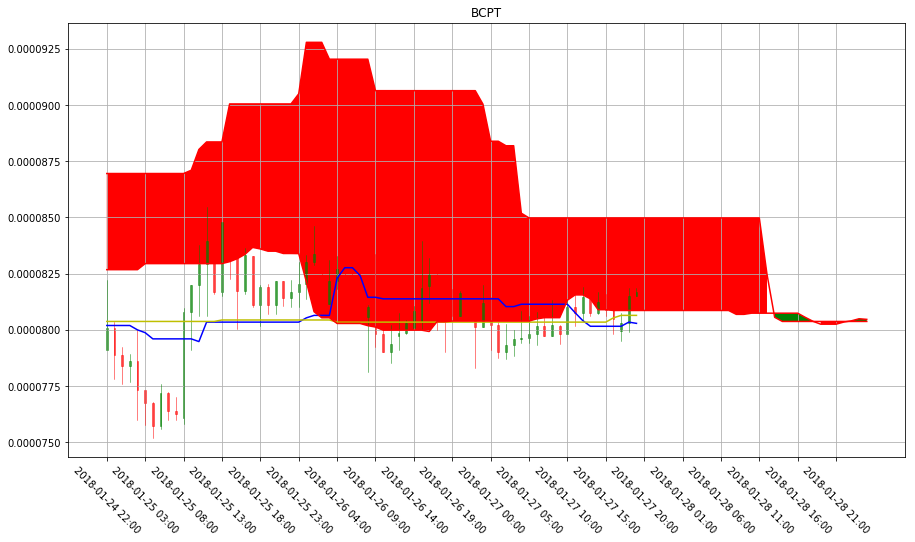

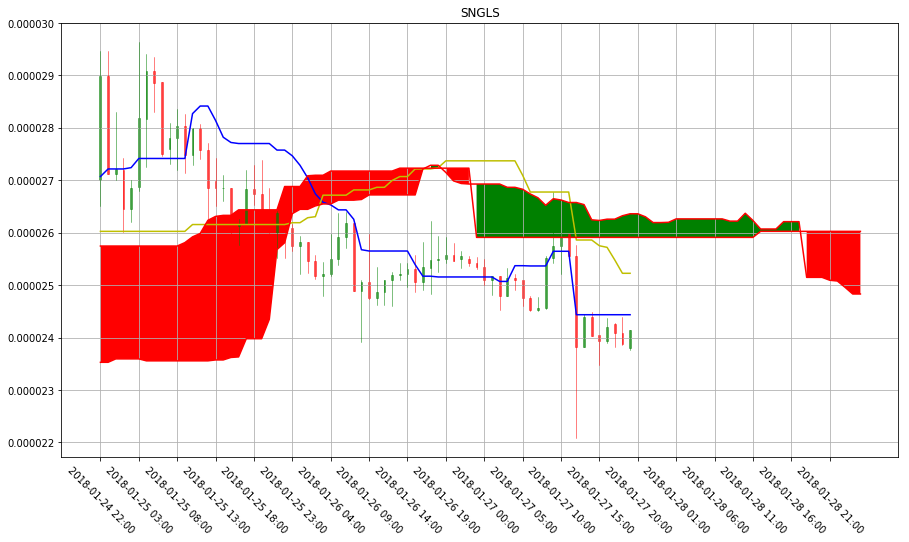

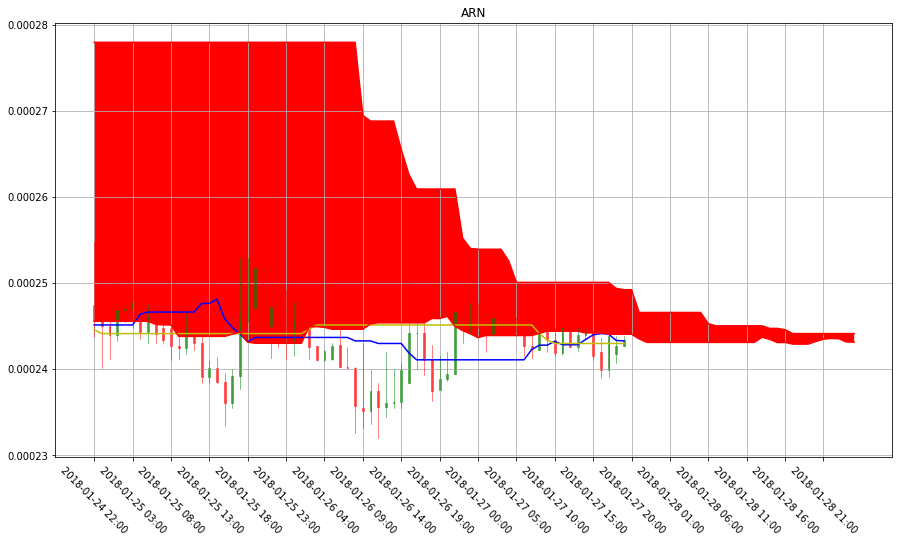

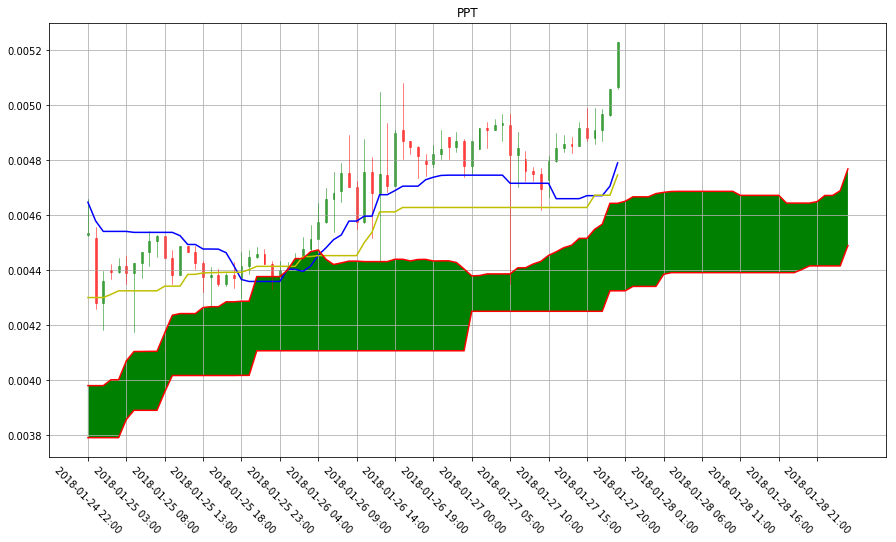

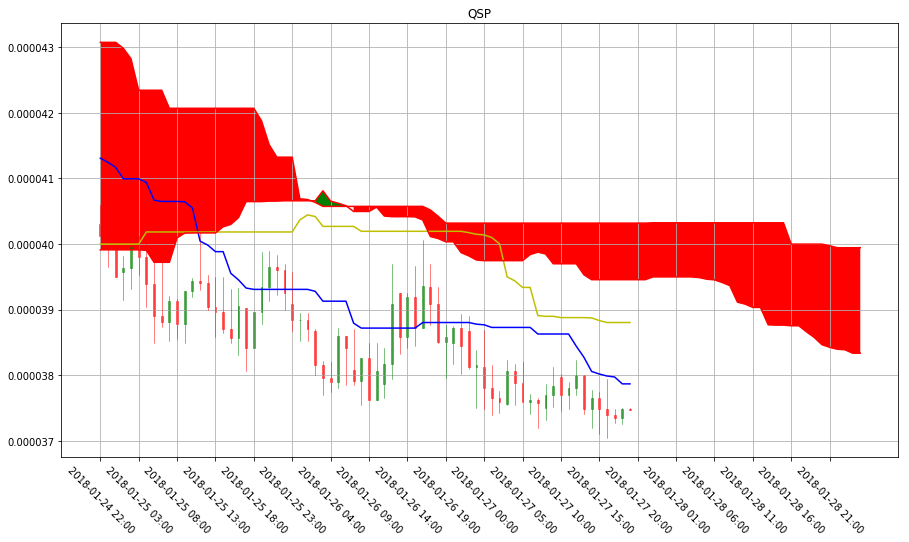

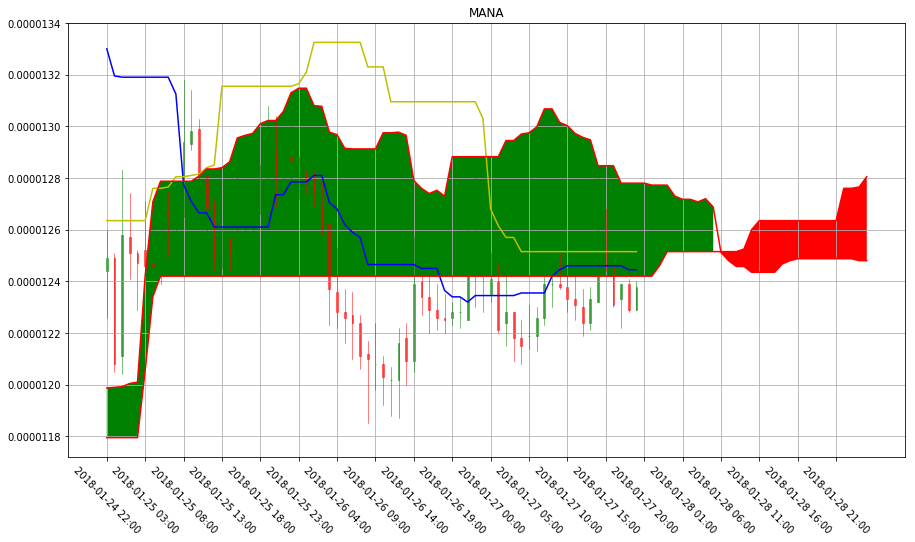

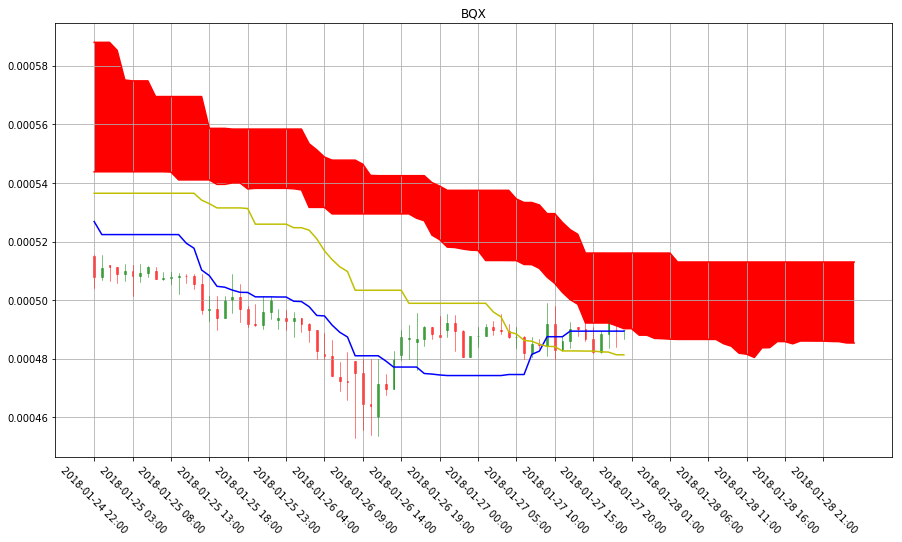

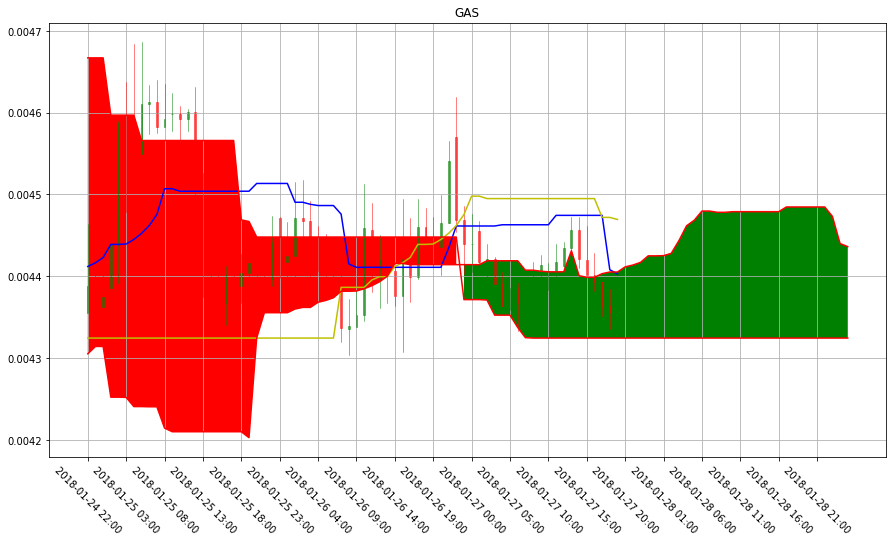

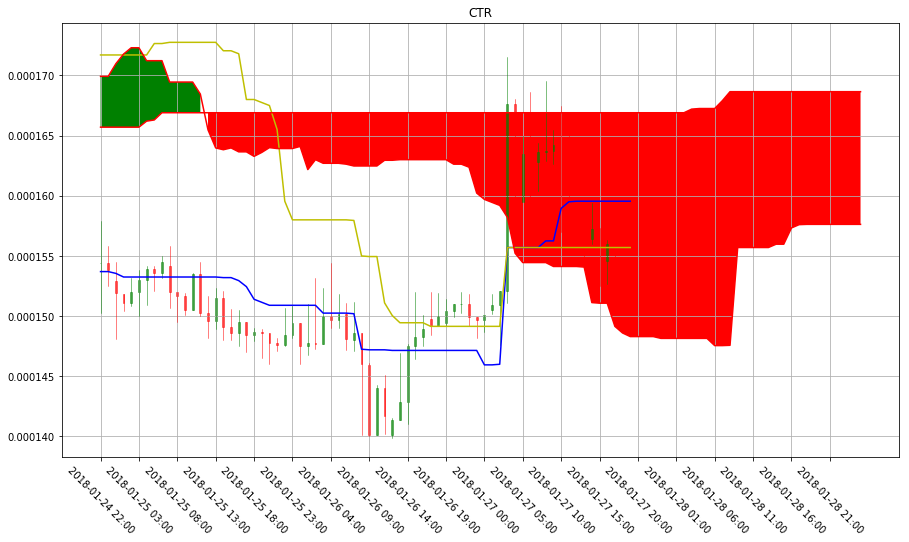

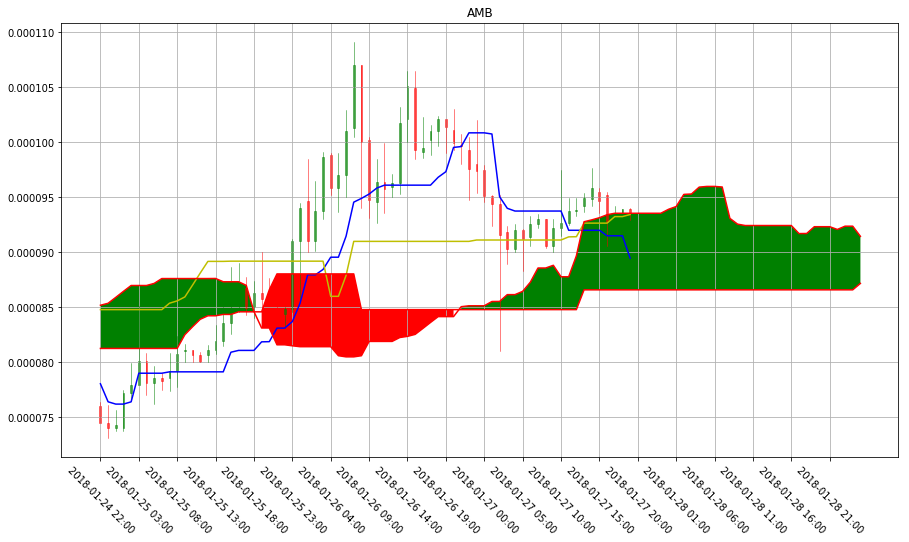

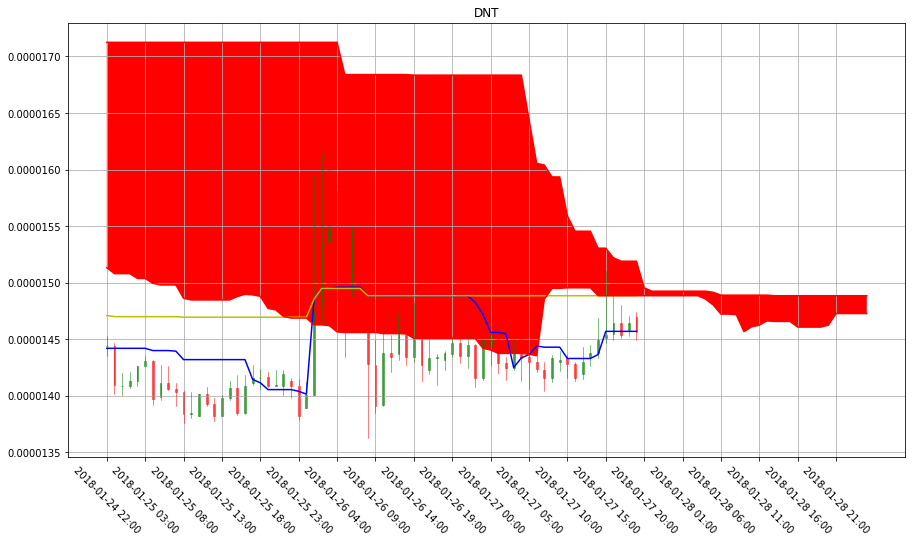

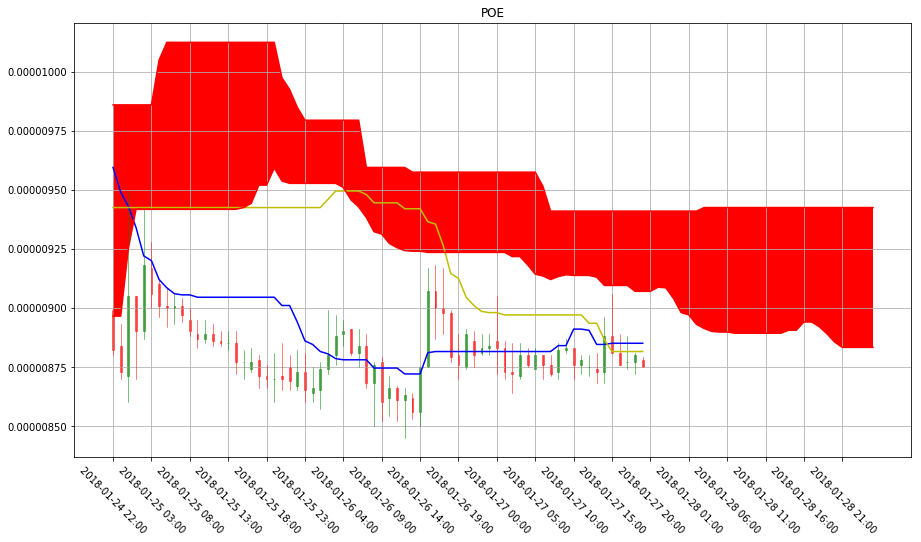

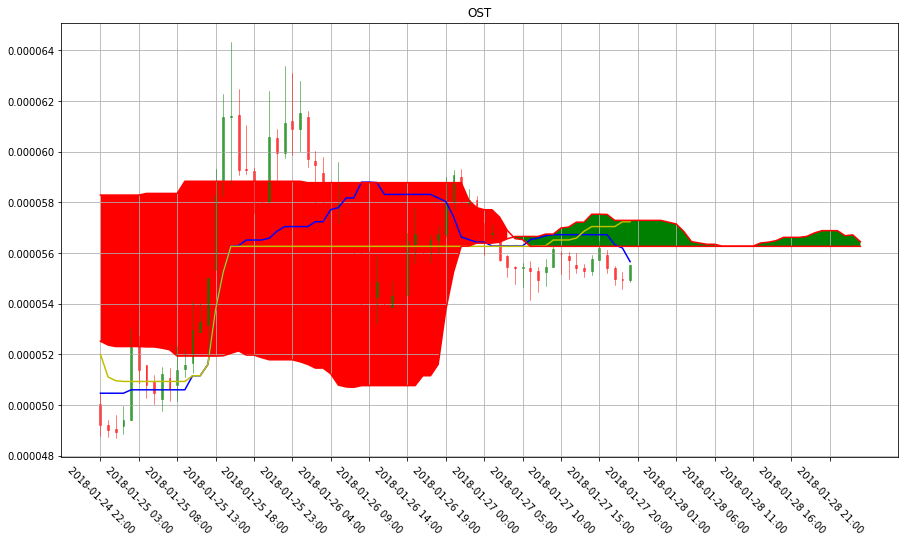

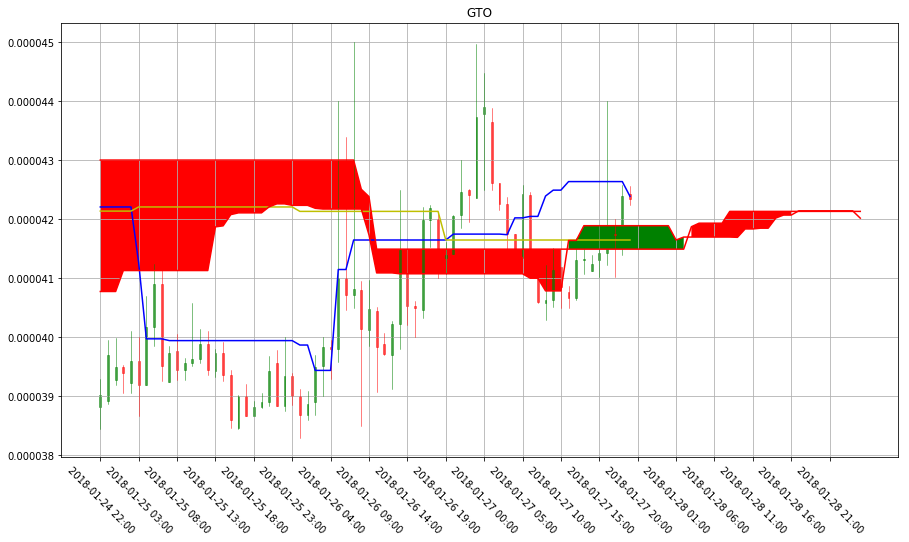

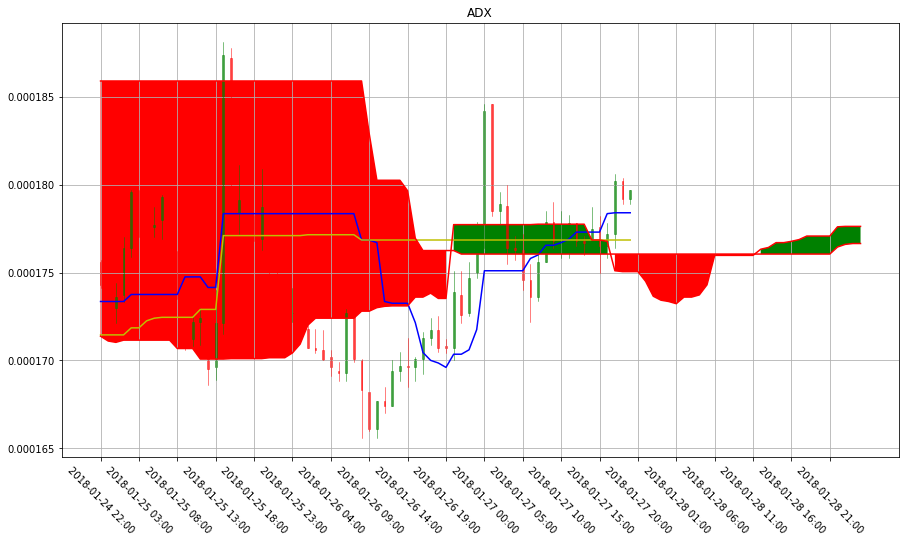

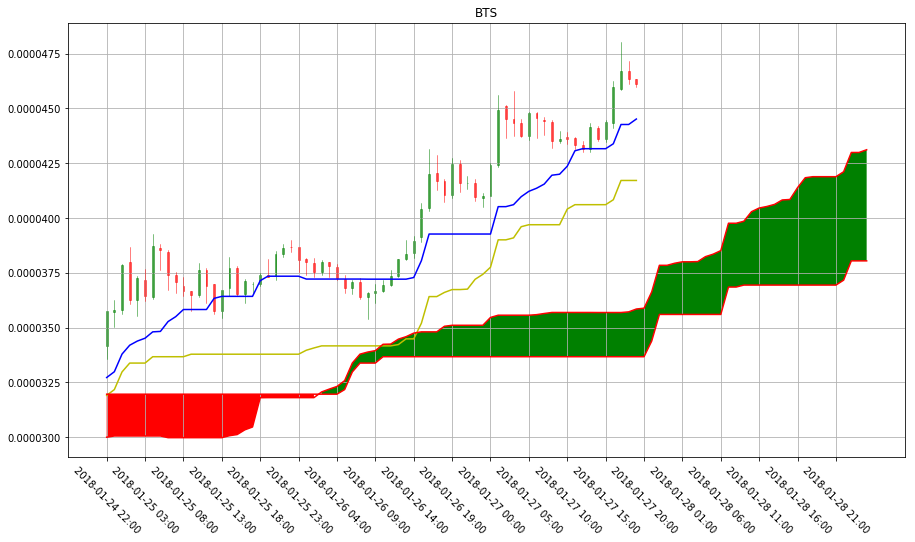

In [ ]:
from crypto.libs.scraping.exchange_scrapping import get_coins_per_exchange
binance = get_coins_per_exchange('binance')
for coin in binance:
    try:
        plot_ichimoku(coin)
    except:
        print(coin)